Table of Contents

1 - Packages

2 - Outline of the Assignment

3 - Convolutional Neural Networks

    3.1 - Zero-Padding
    Exercise 1 - zero_pad

    3.2 - Single Step of Convolution
    Exercise 2 - conv_single_step

    3.3 - Convolutional Neural Networks - Forward Pass
    Exercise 3 - conv_forward

4 - Pooling Layer
   
    4.1 - Forward Pooling
    Exercise 4 - pool_forward

5 - Backpropagation in Convolutional Neural Networks (OPTIONAL / UNGRADED)

    5.1 - Convolutional Layer Backward Pass
    5.1.1 - Computing dA

    5.1.2 - Computing dW
    5.1.3 - Computing db

    Exercise 5 - conv_backward

    5.2 Pooling Layer - Backward Pass
    5.2.1 Max Pooling - Backward Pass  

    Exercise 6 - create_mask_from_window
    5.2.2 - Average Pooling - Backward Pass

    Exercise 7 - distribute_value
    5.2.3 Putting it Together: Pooling Backward

    Exercise 8 - pool_backward

In [ ]:
1 - Packages

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

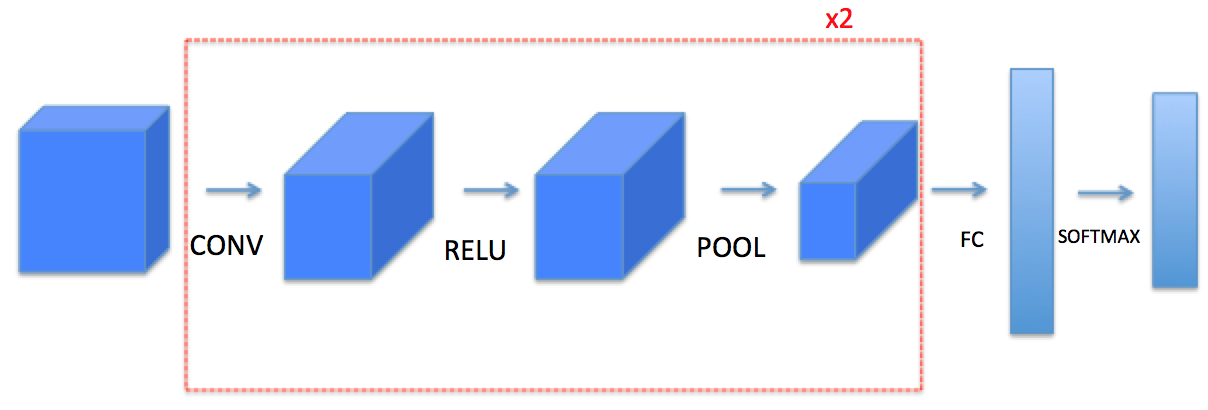

3 - Convolutional Neural Networks
Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below.


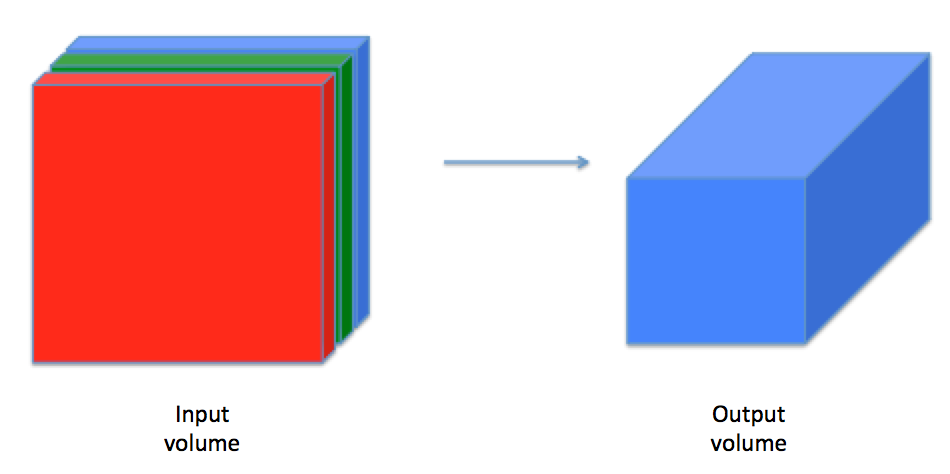

3.1 - Zero-Padding
Zero-padding adds zeros around the border of an image

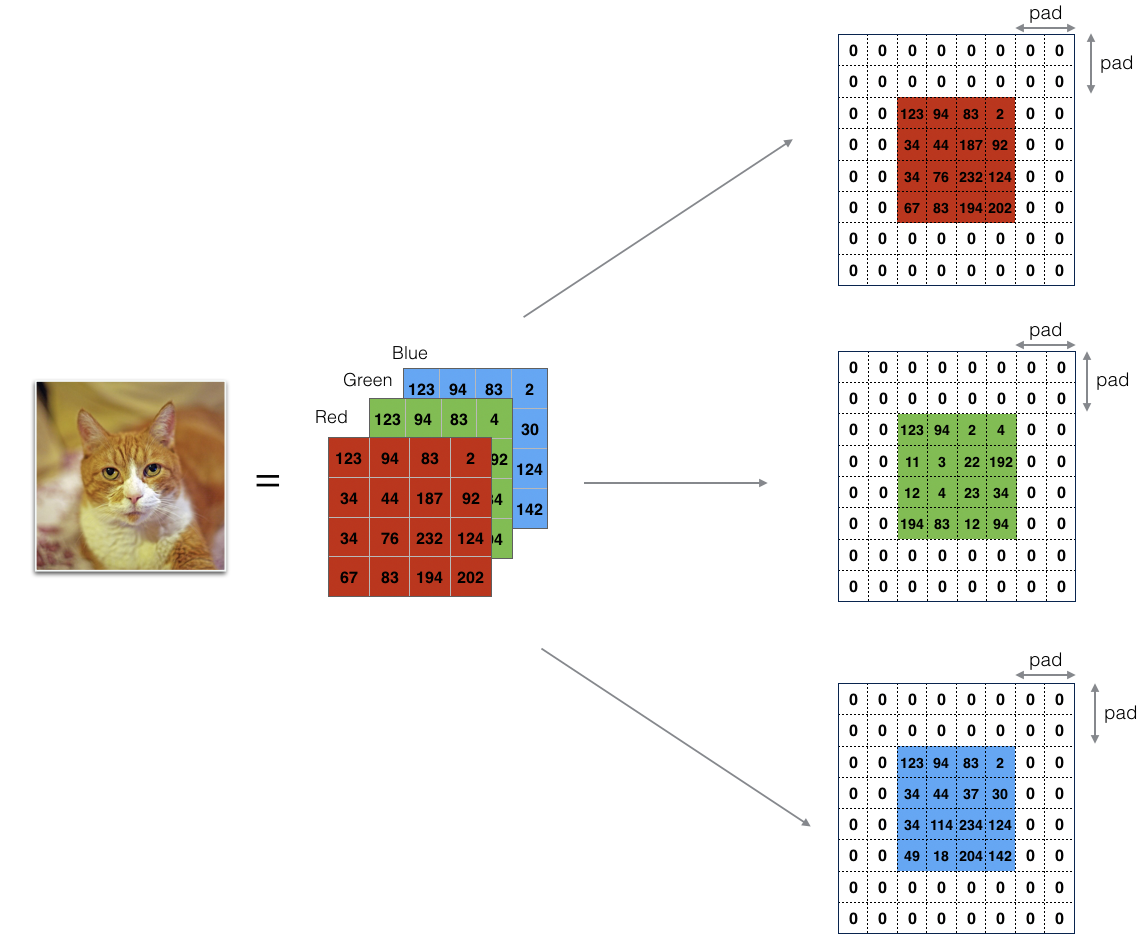

The main benefits of padding are:

It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer.

It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels at the edges of an image.

Exercise 1 - zero_pad

Implement the following function, which pads all the images of a batch of examples X with zeros. Use np.pad.

Note if you want to pad the array "a" of shape  (5,5,5,5,5)
  with pad = 1 for the 2nd dimension, pad = 3 for the 4th dimension and pad = 0 for the rest, you would do:

a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))

In [4]:
def zero_pad(X, pad):
  X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)))
  return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


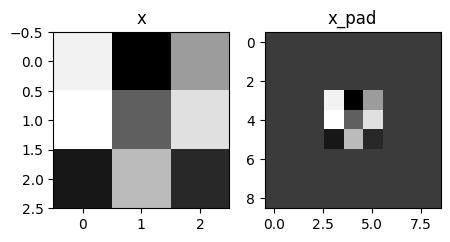

In [5]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])


3.2 - Single Step of Convolution

In this part, implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which:

Takes an input volume
Applies a filter at every position of the input
Outputs another volume (usually of different size)


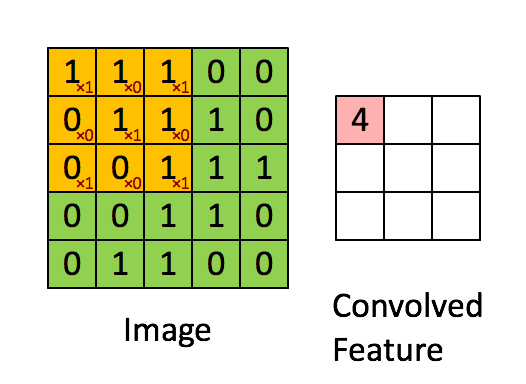

Exercise 2 - conv_single_step

In [6]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev,W)

    Z = np.sum(s)

    b = np.squeeze(b)
    Z = Z + b

    return Z

In [7]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)


assert (type(Z) == np.float64), "You must cast the output to numpy float 64"
assert np.isclose(Z, -6.999089450680221), "Wrong value"

Z = -6.999089450680221


3.3 - Convolutional Neural Networks - Forward Pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume:

In [8]:
def conv_forward(A_prev, W, b, hparameters):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters["stride"]
    pad = hparameters["pad"]


    # Compute the dimensions of the CONV output volume using the formula given above.
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1


    Z = np.zeros((m, n_H, n_W, n_C))

    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            vert_start = stride * h
            vert_end = vert_start  + f

            for w in range(n_W):
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                horiz_start = stride * w
                horiz_end = horiz_start + f

                for c in range(n_C):
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    weights = W[:, :, :, c]
                    biases  = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)


    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [10]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
z_mean = np.mean(Z)
z_0_2_1 = Z[0, 2, 1]
cache_0_1_2_3 = cache_conv[0][1][2][3]
print("Z's mean =\n", z_mean)
print("Z[0,2,1] =\n", z_0_2_1)
print("cache_conv[0][1][2][3] =\n", cache_0_1_2_3)



Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


4 - Pooling Layer

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are:

Max-pooling layer: slides an ( 𝑓,𝑓
 ) window over the input and stores the max value of the window in the output.

Average-pooling layer: slides an ( 𝑓,𝑓
 ) window over the input and stores the average value of the window in the output.

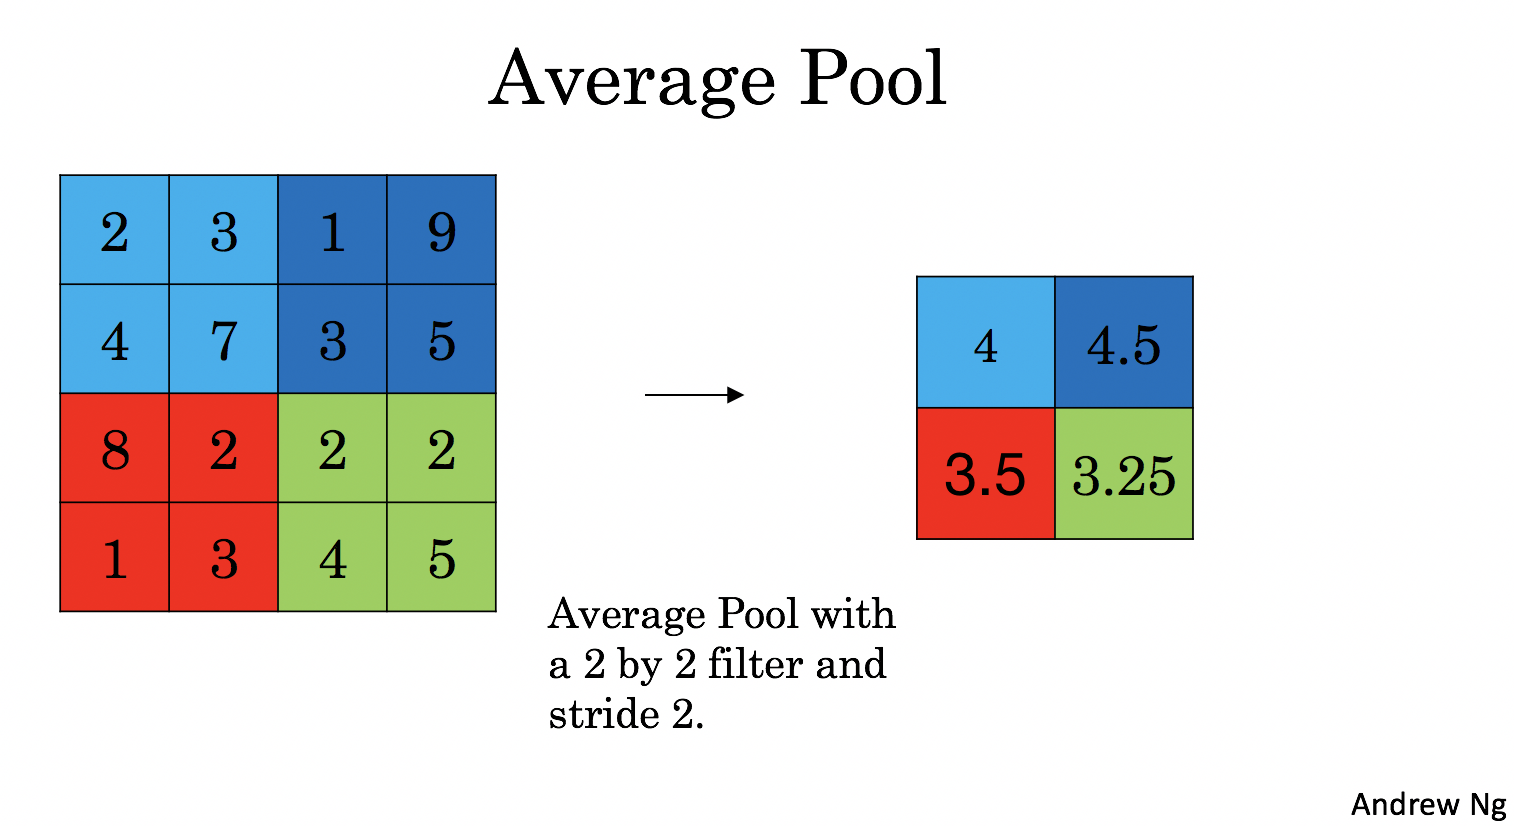

4.1 - Forward Pooling
Now, you are going to implement MAX-POOL and AVG-POOL, in the same function.


Exercise 4 - pool_forward
Implement the forward pass of the pooling layer. Follow the hints in the comments below.

Reminder: As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

𝑛𝐻=⌊𝑛𝐻𝑝𝑟𝑒𝑣−𝑓𝑠𝑡𝑟𝑖𝑑𝑒⌋+1


𝑛𝑊=⌊𝑛𝑊𝑝𝑟𝑒𝑣−𝑓𝑠𝑡𝑟𝑖𝑑𝑒⌋+1


𝑛𝐶=𝑛𝐶𝑝𝑟𝑒𝑣

In [11]:
def pool_forward(A_prev, hparameters, mode = "max"):

    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]

    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))

    for i in range(m):
        a_prev_slice = A_prev[i]
        for h in range(n_H):
            vert_start = stride * h
            vert_end = vert_start + f

            for w in range(n_W):
                horiz_start = stride * w
                horiz_end = horiz_start + f

                for c in range (n_C):

                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_slice_prev = a_prev_slice[vert_start:vert_end,horiz_start:horiz_end,c]

                    # Compute the pooling operation on the slice.

                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice_prev)
                    else:
                        print(mode+ "-type pooling layer NOT Defined")


    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)

    # Making sure your output shape is correct
    #assert(A.shape == (m, n_H, n_W, n_C))

    return A, cache

In [12]:
# Case 1: stride of 1
print("CASE 1:\n")
np.random.seed(1)
A_prev_case_1 = np.random.randn(2, 5, 5, 3)
hparameters_case_1 = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])

# Case 2: stride of 2
print("\n\033[0mCASE 2:\n")
np.random.seed(1)
A_prev_case_2 = np.random.randn(2, 5, 5, 3)
hparameters_case_2 = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])


CASE 1:

mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]
mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]

CASE 2:

mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]


**5.1 - Convolutional Layer Backward Pass**

Let's start by implementing the backward pass for a CONV layer.


**5.1.1 - Computing dA:**

This is the formula for computing  𝑑𝐴
  with respect to the cost for a certain filter  𝑊𝑐
  and a given training example:

𝑑𝐴+=∑ℎ=0𝑛𝐻∑𝑤=0𝑛𝑊𝑊𝑐×𝑑𝑍ℎ𝑤(1)

Where  𝑊𝑐
  is a filter and  𝑑𝑍ℎ𝑤
  is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time, you multiply the same filter  𝑊𝑐
  by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, you are just adding the gradients of all the a_slices.

In code, inside the appropriate for-loops, this formula translates into:

da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]

**5.1.2 - Computing dW:**

This is the formula for computing  𝑑𝑊𝑐
  ( 𝑑𝑊𝑐
  is the derivative of one filter) with respect to the loss:

𝑑𝑊𝑐+=∑ℎ=0𝑛𝐻∑𝑤=0𝑛𝑊𝑎𝑠𝑙𝑖𝑐𝑒×𝑑𝑍ℎ𝑤(2)

Where  𝑎𝑠𝑙𝑖𝑐𝑒
  corresponds to the slice which was used to generate the activation  𝑍𝑖𝑗
 . Hence, this ends up giving us the gradient for  𝑊
  with respect to that slice. Since it is the same  𝑊
 , we will just add up all such gradients to get  𝑑𝑊
 .

In code, inside the appropriate for-loops, this formula translates into:

dW[:,:,:,c] += a_slice * dZ[i, h, w, c]

**5.1.3 - Computing db:**

This is the formula for computing  𝑑𝑏
  with respect to the cost for a certain filter  𝑊𝑐
 :

𝑑𝑏=∑ℎ∑𝑤𝑑𝑍ℎ𝑤(3)

As you have previously seen in basic neural networks, db is computed by summing  𝑑𝑍
 . In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost.

In code, inside the appropriate for-loops, this formula translates into:

db[:,:,:,c] += dZ[i, h, w, c]

In [ ]:
#Exercise 5 - conv_backward

In [14]:
def conv_backward(dZ, cache):

    (A_prev, W, b, hparameters) = cache
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape

    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape

    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(A_prev.shape)
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape) # b.shape = [1,1,1,n_C]

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    for i in range(m):                       # loop over the training examples

        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):

                    # Find the corners of the current "slice"
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f

                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]

        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return dA_prev, dW, db

In [16]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

assert type(dA) == np.ndarray, "Output must be a np.ndarray"
assert type(dW) == np.ndarray, "Output must be a np.ndarray"
assert type(db) == np.ndarray, "Output must be a np.ndarray"
assert dA.shape == (10, 4, 4, 3), f"Wrong shape for dA  {dA.shape} != (10, 4, 4, 3)"
assert dW.shape == (2, 2, 3, 8), f"Wrong shape for dW {dW.shape} != (2, 2, 3, 8)"
assert db.shape == (1, 1, 1, 8), f"Wrong shape for db {db.shape} != (1, 1, 1, 8)"
assert np.isclose(np.mean(dA), 1.4524377), "Wrong values for dA"
assert np.isclose(np.mean(dW), 1.7269914), "Wrong values for dW"
assert np.isclose(np.mean(db), 7.8392325), "Wrong values for db"


dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


**Exercise 6 - create_mask_from_window**

Implement create_mask_from_window(). This function will be helpful for pooling backward. Hints:

np.max() may be helpful. It computes the maximum of an array.
If you have a matrix X and a scalar x: A = (X == x) will return a matrix A of the same size as X such that:

A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x

In [17]:
def create_mask_from_window(x):

    mask = (x == np.max(x))

    return mask

In [19]:
np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x = np.array([[-1, 2, 3],
              [2, -3, 2],
              [1, 5, -2]])

y = np.array([[False, False, False],
     [False, False, False],
     [False, True, False]])
mask = create_mask_from_window(x)

assert type(mask) == np.ndarray, "Output must be a np.ndarray"
assert mask.shape == x.shape, "Input and output shapes must match"
assert np.allclose(mask, y), "Wrong output. The True value must be at position (2, 1)"



x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


In [ ]:
#Exercise 7 - distribute_value

In [20]:
def distribute_value(dz, shape):

    (n_H, n_W ) = shape

    average = np.prod(shape)

    a = (dz/average)*np.ones(shape)
    return a

In [21]:
a = distribute_value(2, (2, 2))
print('distributed value =', a)


assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (2, 2), f"Wrong shape {a.shape} != (2, 2)"
assert np.sum(a) == 2, "Values must sum to 2"

a = distribute_value(100, (10, 10))
assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (10, 10), f"Wrong shape {a.shape} != (10, 10)"
assert np.sum(a) == 100, "Values must sum to 100"



distributed value = [[0.5 0.5]
 [0.5 0.5]]


**Exercise 8 - pool_backward**

Implement the pool_backward function in both modes ("max" and "average"). You will once again use 4 for-loops (iterating over training examples, height, width, and channels). You should use an if/elif statement to see if the mode is equal to 'max' or 'average'. If it is equal to 'average' you should use the distribute_value() function you implemented above to create a matrix of the same shape as a_slice. Otherwise, the mode is equal to 'max', and you will create a mask with create_mask_from_window() and multiply it by the corresponding value of dA.

In [22]:
def pool_backward(dA, cache, mode = "max"):

    (A_prev, hparameters) = cache

    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    f = hparameters["f"]

    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape

    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)

    for i in range(m): # loop over the training examples

        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i,:,:,:]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):

                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start  = h * stride
                    vert_end    = h * stride + f
                    horiz_start = w * stride
                    horiz_end   = w * stride + f

                    # Compute the backward propagation in both modes.
                    if mode == "max":

                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[ vert_start:vert_end, horiz_start:horiz_end, c ]

                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window( a_prev_slice )

                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]

                    elif mode == "average":

                        # Get the value da from dA (≈2 line)
                        da = dA[i, h, w, c]

                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f,f)

                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)


    assert(dA_prev.shape == A_prev.shape)

    return dA_prev

In [23]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
print(A.shape)
print(cache[0].shape)
dA = np.random.randn(5, 4, 2, 2)

dA_prev1 = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev1[1,1] = ', dA_prev1[1, 1])
print()
dA_prev2 = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev2[1,1] = ', dA_prev2[1, 1])

assert type(dA_prev1) == np.ndarray, "Wrong type"
assert dA_prev1.shape == (5, 5, 3, 2), f"Wrong shape {dA_prev1.shape} != (5, 5, 3, 2)"
assert np.allclose(dA_prev1[1, 1], [[0, 0],
                                    [ 5.05844394, -1.68282702],
                                    [ 0, 0]]), "Wrong values for mode max"
assert np.allclose(dA_prev2[1, 1], [[0.08485462,  0.2787552],
                                    [1.26461098, -0.25749373],
                                    [1.17975636, -0.53624893]]), "Wrong values for mode average"


(5, 4, 2, 2)
(5, 5, 3, 2)
mode = max
mean of dA =  0.14571390272918056
dA_prev1[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev2[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
